In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import griddata
import matplotlib.cm as cm

file = 'sample'
json_open = open(file + '.json', 'r', encoding="utf-8")
json_load = json.load(json_open)
# print(json_load)
d = json_load
# print(d.keys())

# ノード情報
nodes = d["data"]["items"]["artifacts"]

# エッジ情報
arr = d["data"]["arrows"]["hasArtifactsOnly"]

lst = [[nodes[i]['id'], nodes[i]['fT'], nodes[i]['sT'], nodes[i]['pos']['y'], nodes[i]['pos']['x']] for i in range(len(nodes))]
df = pd.DataFrame(lst, columns =['id', 'fT', 'sT', 'x', 'y']) 
df.head()

,id,fT,sT,x,y
0,1,RS1,,943.000000,569.000000
1,2,RS2,,748.999999,421.000010
2,3,RS3,,525.999998,563.999998
3,4,RS4,,327.999999,620.999996
4,5,RS5,,101.000000,569.000000


In [20]:
num = np.random.randint(1, 10, 12)
print(num)
df["num"] = num
print(df)

tf_r = df["fT"].str.contains("RS").to_list()
# tf_b = df["fT"].str.contains("BS").to_list()

for i in range(len(df)):
    if tf_r[i]:
        df.iloc[i, 5] = np.random.randint(6, 10)
    else:
        df.iloc[i, 5] = np.random.randint(1, 6)

df

[9 8 6 7 2 6 5 6 3 1 1 4]
    id    fT sT           x            y  num
0    1   RS1     943.000000   569.000000    9
1    2   RS2     748.999999   421.000010    8
2    3   RS3     525.999998   563.999998    6
3    4   RS4     327.999999   620.999996    7
4    5   RS5     101.000000   569.000000    2
5    6   BS1     936.999999  1145.000001    6
6    7   BS2     746.999997  1147.000000    5
7    8   BS3     538.999996  1144.999999    6
8    9   BS4     307.999999   974.000011    3
9   10   BS5      98.999999  1143.000000    1
10  11  RS2'     745.000000   757.999994    1
11  12  BS4'     310.000000  1319.999995    4


,id,fT,sT,x,y,num
0,1,RS1,,943.000000,569.000000,9
1,2,RS2,,748.999999,421.000010,9
2,3,RS3,,525.999998,563.999998,7
3,4,RS4,,327.999999,620.999996,6
4,5,RS5,,101.000000,569.000000,8
5,6,BS1,,936.999999,1145.000001,4
6,7,BS2,,746.999997,1147.000000,1
7,8,BS3,,538.999996,1144.999999,2
8,9,BS4,,307.999999,974.000011,1
9,10,BS5,,98.999999,1143.000000,1


In [21]:
N = df["num"].sum()
df["pot"] = -np.log(df["num"]/N)
df

,id,fT,sT,x,y,num,pot
0,1,RS1,,943.000000,569.000000,9,1.929910
1,2,RS2,,748.999999,421.000010,9,1.929910
2,3,RS3,,525.999998,563.999998,7,2.181224
3,4,RS4,,327.999999,620.999996,6,2.335375
4,5,RS5,,101.000000,569.000000,8,2.047693
5,6,BS1,,936.999999,1145.000001,4,2.740840
6,7,BS2,,746.999997,1147.000000,1,4.127134
7,8,BS3,,538.999996,1144.999999,2,3.433987
8,9,BS4,,307.999999,974.000011,1,4.127134
9,10,BS5,,98.999999,1143.000000,1,4.127134


In [23]:
rels = []

for i in range(len(arr)):
  rels.append([arr[i]["i1"], arr[i]["i2"]])

rels

[[1, 2],
 [2, 3],
 [3, 4],
 [4, 5],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [1, 11],
 [11, 3],
 [8, 12],
 [12, 10]]

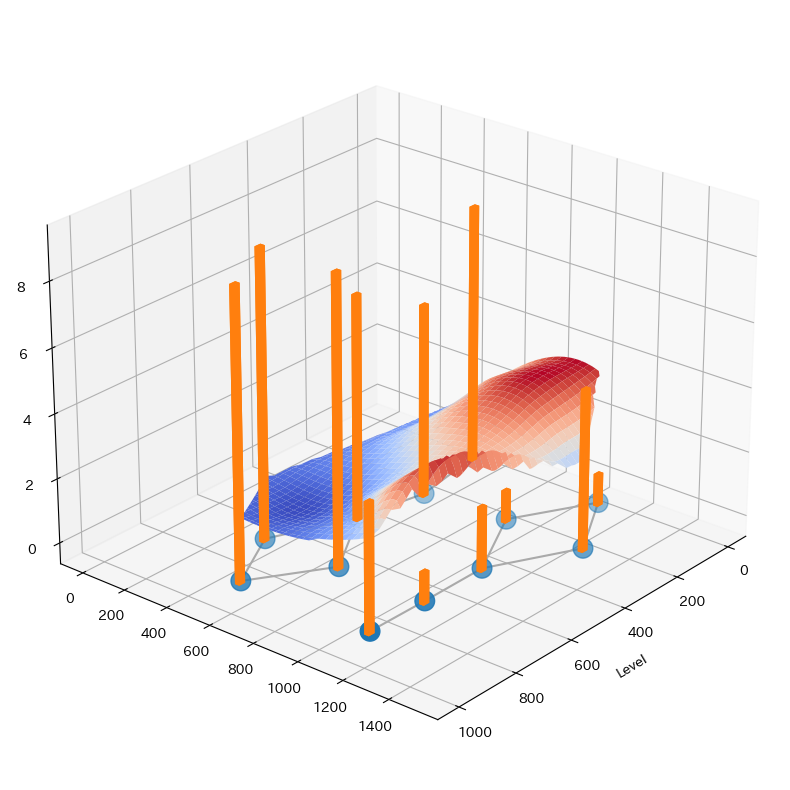

In [35]:
# グラフの作成

G = nx.Graph()
G.add_edges_from(rels)

pos = {df["id"][i] : np.array([df["x"][i], df["y"][i], 0], dtype=np.float32) for i in range(len(df))}
# print(pos)
pos_ary = np.array([pos[n] for n in G])
# print(pos_ary)

# set up the figure and axes
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(111, projection='3d')

ax2.scatter(
    pos_ary[:, 0],
    pos_ary[:, 1],
    pos_ary[:, 2],
    s=200,
)

# ノードにラベルを表示する
# for n in G.nodes:
#     ax2.text(*pos[n], n)

# エッジの表示
for e in G.edges:
    node0_pos = pos[e[0]]
    node1_pos = pos[e[1]]
    xx = [node0_pos[0], node1_pos[0]]
    yy = [node0_pos[1], node1_pos[1]]
    zz = [node0_pos[2], node1_pos[2]]
    ax2.plot(xx, yy, zz, c="#aaaaaa")

# bar graph code
x, y, z = df["x"], df["y"], df["num"]
# print(x, y, z)
top = z
bottom = np.zeros_like(top)
width = 20
depth = 20
ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
# ax2.set_title('支持者数')

# surface plot code
X, Y, Z = df["x"], df["y"], df["pot"]

points = np.array([X, Y]).T

# create a grid of coordinates between the minimum and
# maximum of your X and Y. 50j indicates 50 discretization
# points between the minimum and maximum.
X_grid, Y_grid = np.mgrid[1:1000:100j, 1:1500:100j]
# interpolate your values on the grid defined above
Z_grid = griddata(points, Z, (X_grid, Y_grid), method='cubic')

ax2.plot_surface(X_grid, Y_grid, Z_grid, cmap=cm.coolwarm, 
                       linewidth=0, antialiased=True)

ax2.view_init(elev= 25, azim=40, roll=0)

ax2.set_xlabel('Level')
# ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z')
# plt.savefig("pot_network_%s.png" % file)

plt.show()

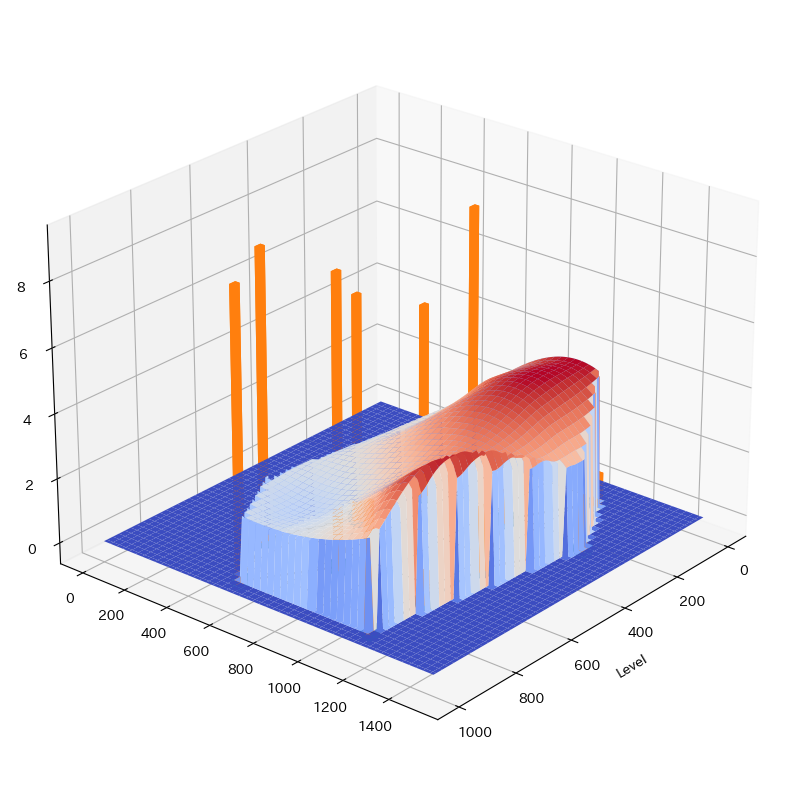

In [36]:
# グラフの作成

G = nx.Graph()
G.add_edges_from(rels)

pos = {df["id"][i] : np.array([df["x"][i], df["y"][i], 0], dtype=np.float32) for i in range(len(df))}
# print(pos)
pos_ary = np.array([pos[n] for n in G])
# print(pos_ary)

# set up the figure and axes
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(111, projection='3d')

ax2.scatter(
    pos_ary[:, 0],
    pos_ary[:, 1],
    pos_ary[:, 2],
    s=200,
)

# ノードにラベルを表示する
# for n in G.nodes:
#     ax2.text(*pos[n], n)

# エッジの表示
for e in G.edges:
    node0_pos = pos[e[0]]
    node1_pos = pos[e[1]]
    xx = [node0_pos[0], node1_pos[0]]
    yy = [node0_pos[1], node1_pos[1]]
    zz = [node0_pos[2], node1_pos[2]]
    ax2.plot(xx, yy, zz, c="#aaaaaa")

# bar graph code
x, y, z = df["x"], df["y"], df["num"]
# print(x, y, z)
top = z
bottom = np.zeros_like(top)
width = 20
depth = 20
ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
# ax2.set_title('支持者数')

# surface plot code
X, Y, Z = df["x"], df["y"], df["pot"]

points = np.array([X, Y]).T

# create a grid of coordinates between the minimum and
# maximum of your X and Y. 50j indicates 50 discretization
# points between the minimum and maximum.
X_grid, Y_grid = np.mgrid[1:1000:100j, 1:1500:100j]
# interpolate your values on the grid defined above
Z_grid = griddata(points, Z, (X_grid, Y_grid), method='cubic')

Z_d = np.nan_to_num(Z_grid)

ax2.plot_surface(X_grid, Y_grid, Z_d, cmap=cm.coolwarm, 
                       linewidth=0, antialiased=True)

ax2.view_init(elev= 25, azim=40, roll=0)

ax2.set_xlabel('Level')
# ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z')
# plt.savefig("pot_network_%s.png" % file)

plt.show()